In [2]:
from control.matlab import tf
import numpy as np
import matplotlib.pyplot as plt

"""
後で使う関数の定義
"""

def linestyle_generator():
    """グラフをプロットするときの線種を決めるジェネレータ"""
    linestyle = ['-', '--', '-.', ':']
    lineID = 0
    while True:
        yield linestyle[lineID]
        lineID = (lineID + 1) % len(linestyle)

def plot_set(fig_ax, *args):
    """グラフを整える"""
    fig_ax.set_xlabel(args[0])
    fig_ax.set_ylabel(args[1])
    fig_ax.grid(ls=':')
    if len(args) == 3:
        fig_ax.legend(loc=args[2])

def bodeplot_set(fig_ax, *args):
    """ボード線図を整える"""
    # ゲイン線図
    fig_ax[0].grid(which="both", ls=':')
    fig_ax[0].set_ylabel('Gain [dB]')

    # 位相線図
    fig_ax[1].grid(which="both", ls=':')
    fig_ax[1].set_xlabel('omega [rad/s]')
    fig_ax[1].set_ylabel('Phase [deg]')

    # 凡例
    if len(args) > 0:
        fig_ax[1].legend(loc=args[0])
    if len(args) > 1:
        fig_ax[0].legend(loc=args[1])

"""
垂直駆動アームのモデル
"""

g = 9.81
l = 0.2
M = 0.5
mu = 1.5e-2
J = 1.0e-2

P = tf([0, 1], [J, mu, M*g*l])

ref = 30 # 目標角度

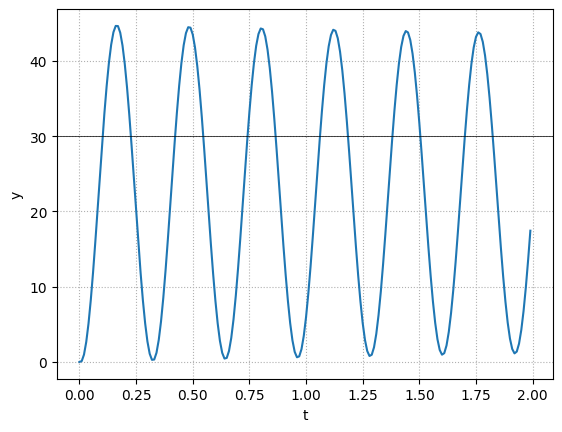

In [4]:
from control.matlab import tf, feedback, step, pade
import numpy as np

num_delay, den_delay = pade(0.005, 1)
Pdelay = P * tf(num_delay, den_delay)

kp0 = 2.9 # 比例ゲイン
K = tf([0, kp0], [0, 1])
Gyr = feedback(Pdelay * K, 1) # 閉ループ系
y, t = step(Gyr, np.arange(0, 2, 0.01)) # ステップ応答

fig, ax = plt.subplots()
ax.plot(t, y * ref)
ax.axhline(ref, color="k", linewidth=0.5)
plot_set(ax, 't', 'y')


rule: classic
kp: 1.74
ki: 11.6
kd: 0.06525
----------------
rule: no overshoot
kp: 0.58
ki: 3.8666666666666667
kd: 0.05742
----------------


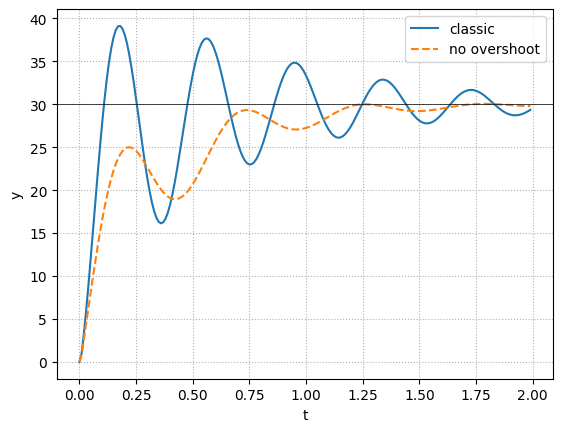

In [7]:
kp = [0, 0]
ki = [0, 0]
kd = [0, 0]
Rule = ['', '']

T0 = 0.3

# 限界感度法(classic)
Rule[0] = 'classic'
kp[0] = 0.6 * kp0
ki[0] = kp[0] / (0.5 * T0)
kd[0] = kp[0] * (0.125 * T0)

# 改良された限界感度法
Rule[1] = 'no overshoot'
kp[1] = 0.2 * kp0
ki[1] = kp[1] / (0.5 * T0)
kd[1] = kp[1] * (0.33 * T0)

LS = linestyle_generator()
fig, ax = plt.subplots()

for i in range(2):
    K = tf([kd[i], kp[i], ki[i]], [1, 0])
    Gyr = feedback(Pdelay * K, 1)
    y, t = step(Gyr, np.arange(0, 2, 0.01))
    ax.plot(t, y * ref, ls=next(LS), label=Rule[i])

    print(f"rule: {Rule[i]}")
    print(f"kp: {kp[i]}")
    print(f"ki: {ki[i]}")
    print(f"kd: {kd[i]}")
    print("----------------")

ax.axhline(ref, color="k", linewidth=0.5)
plot_set(ax, 't', 'y', 'best')